In [1]:
%pip install nltk
%pip install spark-nlp
%pip install --upgrade spark-nlp
%pip install pandas
%pip install mysql-connector-python
%pip install pyspark
%pip install matplotlib
%pip install plotly
%pip install seaborn


import pandas as pd
import mysql.connector
from pyspark.sql import SparkSession
import time

spark = SparkSession.builder.config("spark.jars", "/usr/share/java/mysql-connector-j-8.0.31.jar") \
    .master("local[2]").appName("Final_Project").getOrCreate()

# Record start time
start_time = time.time()


original = spark.read.json("./reddit-data.json")
df = original

df.show()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached spark_nlp-5.2.0-py2.py3-none-any.whl.metadata (55 kB)
Using cached spark_nlp-5.2.0-py2.py3-none-any.whl (548 kB)
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 5.1.4
    Uninstalling spark-nlp-5.1.4:
      Successfully uninstalled spark-nlp-5.1.4
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


23/12/08 22:09:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+-----------+----------+--------+--------------------+-------+-------------+--------------------+
|numComments|numUpvotes|postBody|        postComments| postID|     postTime|           postTitle|
+-----------+----------+--------+--------------------+-------+-------------+--------------------+
|       NULL|      NULL|    NULL|                NULL|   NULL|         NULL|                NULL|
|         70|       317|        |[Hi all,\n\nA rem...|17jcqmj|1.698613842E9|The federal defic...|
|        145|      1036|        |[Hi all,\n\nA rem...|17j3ruj|1.698588734E9|The ‘great wealth...|
|        238|      1190|        |[Hi all,\n\nA rem...|17j0lr4|1.698577439E9|Check Your Email:...|
|         17|       113|        |[Hi all,\n\nA rem...|17jcyv4|1.698614455E9|The ‘great wealth...|
|        142|       375|        |[Hi all,\n\nA rem...|17j3rhj|1.698588704E9|When Idiot Savant...|
|          1|        23|        |[Hi all,\n\nA rem...|17jklhk|1.698637256E9|More Americans fa...|
|         47|       

Downloading training data

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk
import os

test_df = spark.read.csv("./twitter_sentiment_train.csv", inferSchema=True)

#test_df.show()

test_df = test_df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
    .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
test_df.show(5)
print(f"There are {test_df.count()} rows and  {len(test_df.columns)} columns in the dataset.")

test_df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in test_df.columns]).toPandas().head()
# Handle duplicates
test_df = test_df.dropDuplicates()

drop_cols= ("id","date","flag","user")
test_df = test_df.drop(*drop_cols)
#test_df.show(5, truncate = False)

test_df.createOrReplaceTempView('temp')
test_df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
#test_df.tail(5)

#test_df.groupBy("label").count().show()

from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

clean_text = func.udf(lambda x: preprocess(x), StringType())

test_df = test_df.withColumn('text_cleaned',clean_text(func.col("text")))
#test_df.show(5)

df = df.drop("text")

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



There are 1600000 rows and  6 columns in the dataset.


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...          
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(test_df)
#words_tokens.show(5)

from pyspark.ml.feature import CountVectorizer

count = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
#featurizedData.show(5)

from pyspark.ml.feature import IDF

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show(5) 

df_final = rescaledData.select("label", "features")

seed = 42  # set seed for reproducibility
trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

trainDF.groupby("label").count().show() # to see if there is any bias

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
model = lr.fit(trainDF) # Yes its just one line! every ML is just "Fit" ;)

predictions = model.transform(testDF)
pred = predictions.toPandas()
#pred.head()

23/12/08 22:10:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:10:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:10:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:10:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:11:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:11:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:11:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:11:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:11:42 WARN DAGScheduler: Broadcasting large task bin

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[7],[3.24...|
|  0.0|(262144,[2,26,30,...|
|  0.0|(262144,[25,33,10...|
|  0.0|(262144,[4,56,235...|
|  0.0|(262144,[12,18,35...|
+-----+--------------------+
only showing top 5 rows



23/12/08 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:12:35 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/12/08 22:13:16 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


+-----+------+
|label| count|
+-----+------+
|  0.0|560011|
|  1.0|560238|
+-----+------+



23/12/08 22:13:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:13:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:13:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:13:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:13:29 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/12/08 22:14:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/08 22:14:10 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/12/08 22:14:50 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/12/08 22:14:51 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
23/12/08 22:14:51 WARN DAGScheduler: Broadcasting large task binary with size 6.8

In [4]:

from pyspark.sql.functions import col, unix_timestamp, from_unixtime, date_format
import datetime

unix_time = 1609459200  

# Convert Unix time to a datetime object
datetime_object = datetime.datetime.utcfromtimestamp(unix_time)

# Format the datetime object as a string
formatted_date = datetime_object.strftime('%Y-%m-%d %H:%M:%S')

print(formatted_date)

df = df.withColumn("formattedTime", from_unixtime("postTime", format="yyyy-MM-dd HH:mm:ss"))

df = df.drop("postTime")
#df = df.drop("formattedTime")
df = df.drop("postID")

#df.show()


2021-01-01 00:00:00


In [5]:
from pyspark.sql.functions import col, concat_ws

# combining title and body of post into a single text column
df = df.withColumn("combinedTextColumn", concat_ws(" ", col("postTitle"), col("postBody")))

tokenizer_reddit = Tokenizer(inputCol="combinedTextColumn", outputCol="words_tokens")
words_tokens_reddit = tokenizer_reddit.transform(df)
#words_tokens_reddit.show(5)

count_reddit = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model_reddit = count_reddit.fit(words_tokens_reddit)
featurizedData_reddit = model_reddit.transform(words_tokens_reddit)
#featurizedData_reddit.show(5)

idf_reddit = IDF(inputCol="rawFeatures", outputCol="features")
idfModel_reddit = idf_reddit.fit(featurizedData)
rescaledData_reddit = idfModel_reddit.transform(featurizedData)

#rescaledData_reddit.show(5) 


from pyspark.sql.functions import lit

reddit_df = rescaledData_reddit.select("features")
reddit_df = reddit_df.withColumn("label", lit(0.0))

reddit_df = reddit_df[['label', 'features']]


limited_df = reddit_df.limit(20000)

predictions_reddit = model.transform(limited_df)
pred_reddit = predictions_reddit.toPandas()
pred_reddit.head()


23/12/08 22:16:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:16:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:16:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:16:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:16:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/08 22:17:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:17:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:17:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/08 22:17:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will no

,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.24530063...","[0.6135501099629687, -0.6135501099629687]","[0.6487502042043846, 0.35124979579561544]",0.0
1,0.0,"(0.0, 0.0, 3.0071857325997775, 0.0, 0.0, 0.0, ...","[3.181183841594867, -3.181183841594867]","[0.9601200195291572, 0.039879980470842846]",0.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.1498605739503651, -1.1498605739503651]","[0.7594854492902872, 0.24051455070971284]",0.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 3.1167571186782292, 0.0, ...","[3.5639792210923695, -3.5639792210923695]","[0.9724543691786268, 0.02754563082137318]",0.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.4572988879449933, 2.4572988879449933]","[0.07890643139151596, 0.921093568608484]",1.0


In [6]:
from pyspark.sql.functions import monotonically_increasing_id

tempSpark_df = spark.createDataFrame(pred_reddit)

tempSpark_df = tempSpark_df.withColumn("id", monotonically_increasing_id())
df = df.withColumn("id", monotonically_increasing_id())

df = df.join(tempSpark_df, "id")
df.show()

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
23/12/08 22:17:29 WARN TaskSetManager: Stage 72 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|  id|numComments|numUpvotes|            postBody|        postComments|           postTitle|      formattedTime|  combinedTextColumn|label|            features|       rawPrediction|         probability|prediction|
+----+-----------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|  26|          1|        19|                    |[Hi all,\n\nA rem...|Poland changes co...|2023-10-28 15:00:01|Poland changes co...|  0.0|(262144,[63,116,4...|[0.32649517539167...|[0.58090635546324...|       0.0|
|  29|          1|         7|                    |[Hi all,\n\nA rem...|Nomura reassesses...|2023-10-28 16:32:41|Nomura reassesses...|  0.0|(2621

SAVE POINT

In [7]:
save_point_pred_reddit = pred_reddit
save_point_spark_pred_reddit = tempSpark_df
save_point_df = df

In [8]:
df = save_point_df
df = df.drop("features")
df = df.drop("rawPrediction")
df = df.drop("label")
df = df.drop("postComments")
df = df.withColumnRenamed("probability", "textProbability")

df.show()


23/12/08 22:17:32 WARN TaskSetManager: Stage 78 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|  id|numComments|numUpvotes|            postBody|           postTitle|      formattedTime|  combinedTextColumn|     textProbability|prediction|
+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|  26|          1|        19|                    |Poland changes co...|2023-10-28 15:00:01|Poland changes co...|[0.58090635546324...|       0.0|
|  29|          1|         7|                    |Nomura reassesses...|2023-10-28 16:32:41|Nomura reassesses...|[0.98438761401133...|       0.0|
| 474|          9|       281|                    |Trump’s claim tha...|2023-10-12 23:10:24|Trump’s claim tha...|[0.56244640768897...|       0.0|
| 964|        141|      1719|                    |Clarence Thomas S...|2023-09-22 11:04:02|Clarence Thomas S...|[0.99381053205934.

In [9]:
corr_df = df.select("numComments","numUpvotes","prediction")
corr_df.show()

23/12/08 22:17:35 WARN TaskSetManager: Stage 84 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+-----------+----------+----------+
|numComments|numUpvotes|prediction|
+-----------+----------+----------+
|          1|        19|       0.0|
|          1|         7|       0.0|
|          9|       281|       0.0|
|        141|      1719|       0.0|
|         36|       108|       0.0|
|          4|         0|       0.0|
|          8|         0|       0.0|
|          1|         2|       0.0|
|          4|         4|       0.0|
|          5|         1|       0.0|
|          7|         8|       0.0|
|        572|     23504|       0.0|
|        681|     15356|       1.0|
|        496|     14332|       0.0|
|         15|     30259|       0.0|
|        146|      2858|       0.0|
|        134|      1737|       1.0|
|         35|      1464|       0.0|
|         76|      4958|       0.0|
|        478|      4457|       1.0|
+-----------+----------+----------+
only showing top 20 rows



In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

comments_correlation_coefficient = corr_df.corr("prediction","numComments")
upvotes_correlation_coefficient = corr_df.corr("prediction","numUpvotes")

23/12/08 22:17:37 WARN TaskSetManager: Stage 90 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:17:39 WARN TaskSetManager: Stage 99 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


23/12/08 22:17:41 WARN TaskSetManager: Stage 108 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


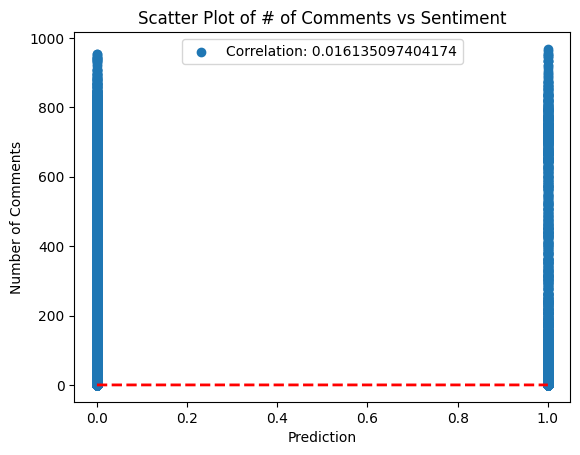

In [11]:
# Convert the DataFrame to Pandas for plotting
pandas_corr_df = corr_df.toPandas()

# Plot the two columns for numOfComments to sentiment correlation
#plt.scatter(pandas_corr_df["prediction"], pandas_corr_df["numComments"], label=f"Correlation: {comments_correlation_coefficient}")
plt.scatter(pandas_corr_df["prediction"], pandas_corr_df["numComments"], label="Correlation: {}".format(comments_correlation_coefficient))

# Add a line representing the correlation coefficient
plt.plot([pandas_corr_df["prediction"].min(), pandas_corr_df["prediction"].max()],
         [pandas_corr_df["prediction"].min() * comments_correlation_coefficient, pandas_corr_df["prediction"].max() * comments_correlation_coefficient],
         color='red', linestyle='--', linewidth=2)

# Set labels and title
plt.xlabel("Prediction")
plt.ylabel("Number of Comments")
plt.title("Scatter Plot of # of Comments vs Sentiment")

# Show the legend
plt.legend()

# Show the plot
plt.show()

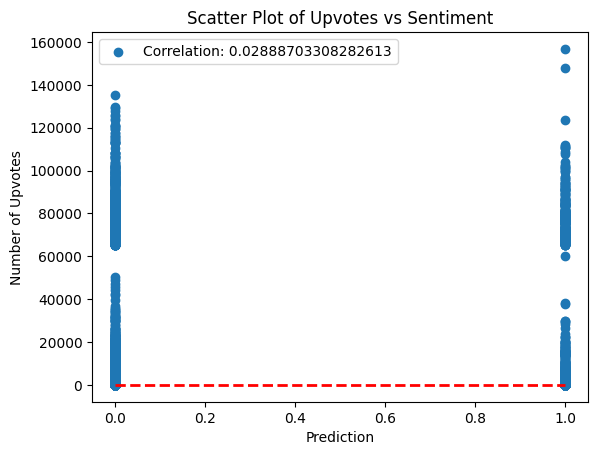

In [12]:
# Plot the two columns for numOfUpvotes to sentiment correlation
plt.scatter(pandas_corr_df["prediction"], pandas_corr_df["numUpvotes"], label="Correlation: {}".format(upvotes_correlation_coefficient))

# Add a line representing the correlation coefficient
plt.plot([pandas_corr_df["prediction"].min(), pandas_corr_df["prediction"].max()],
         [pandas_corr_df["prediction"].min() * upvotes_correlation_coefficient, pandas_corr_df["prediction"].max() * upvotes_correlation_coefficient],
         color='red', linestyle='--', linewidth=2)

# Set labels and title
plt.xlabel("Prediction")
plt.ylabel("Number of Upvotes")
plt.title("Scatter Plot of Upvotes vs Sentiment")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [13]:
# Record end time
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 474.33725476264954 seconds


In [14]:
# execution time for 1 worker: Execution Time: 490.91757225990295 seconds
one_worker = execution_time

In [15]:
one_worker

474.33725476264954

In [16]:
# execution time for 2 workers: Execution Time: 421.2560045719147 seconds 

two_workers = execution_time
two_workers

474.33725476264954

In [17]:
# execution time for * workers: Execution Time: 415.56869554519653 seconds seconds
star_workers = execution_time
star_workers

474.33725476264954

In [18]:
#Data size = 20mb, 2 workers: Execution Time: 416.9236385822296 seconds
two_workers = execution_time
two_workers

474.33725476264954

In [19]:
#Data size = 90mb, 2 workers: Execution Time: 427.77132272720337 seconds
two_workers = execution_time
two_workers

474.33725476264954

Evaluation Graphs

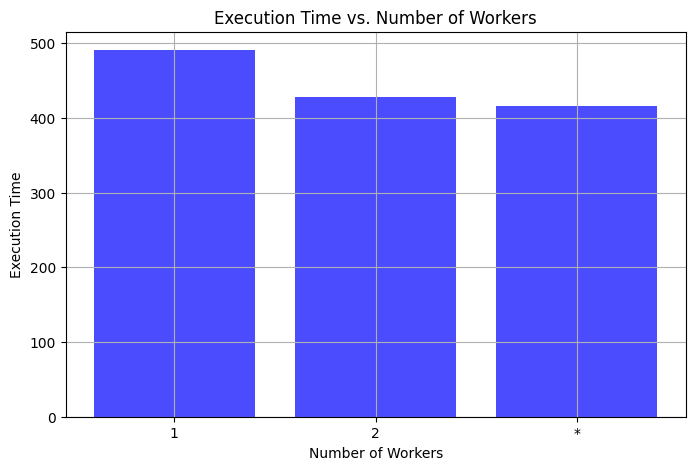

In [20]:
import matplotlib.pyplot as plt
columns1 = ["Number of Workers", "Execution Time"]
data1 = [("1", 490.9176),
        ("2", 428.1602),
        ("*", 415.5687)]

evaluation_graph1 = spark.createDataFrame(data1, columns1)

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = evaluation_graph1.toPandas()

# Plot the data as a bar plot
plt.figure(figsize=(8, 5))

plt.bar(pandas_df["Number of Workers"], pandas_df["Execution Time"], color='blue', alpha=0.7)
plt.title("Execution Time vs. Number of Workers")
plt.xlabel("Number of Workers")
plt.ylabel("Execution Time")

plt.grid(True)
plt.show()

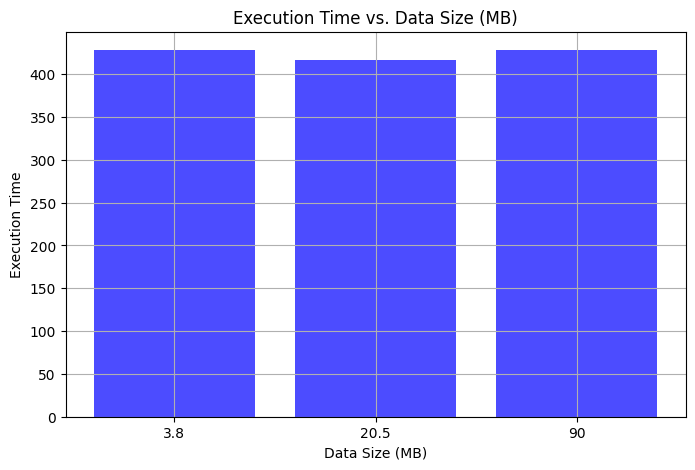

In [21]:
columns2 = ["Data Size (MB)", "Execution Time"]
data2 = [("3.8", 428.1602),
        ("20.5", 416.9236),
        ("90", 427.7713)]

evaluation_graph2 = spark.createDataFrame(data2, columns2)

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df2 = evaluation_graph2.toPandas()

# Plot the data as a bar plot
plt.figure(figsize=(8, 5))

plt.bar(pandas_df2["Data Size (MB)"], pandas_df2["Execution Time"], color='blue', alpha=0.7)
plt.title("Execution Time vs. Data Size (MB)")
plt.xlabel("Data Size (MB)")
plt.ylabel("Execution Time")

plt.grid(True)
plt.show()

WordCloud

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import lower

from pyspark.sql.types import StringType

df = df.withColumn("processedTextColumn", lower('combinedTextColumn'))
df = df.na.drop(subset=["processedTextColumn"])


def assign_party_label(text):
    if 'democrat' in text:
        return '"D"'
    elif 'republican' in text:
        return '"R"'
    else:
        return '"N"'

assign_party_label_udf = udf(assign_party_label, StringType())
df = df.withColumn("partyLabel", assign_party_label_udf('processedTextColumn'))


print(df.show())

23/12/08 22:17:45 WARN TaskSetManager: Stage 116 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+
|  id|numComments|numUpvotes|            postBody|           postTitle|      formattedTime|  combinedTextColumn|     textProbability|prediction| processedTextColumn|partyLabel|
+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+
|  26|          1|        19|                    |Poland changes co...|2023-10-28 15:00:01|Poland changes co...|[0.58090635546324...|       0.0|poland changes co...|       "N"|
|  29|          1|         7|                    |Nomura reassesses...|2023-10-28 16:32:41|Nomura reassesses...|[0.98438761401133...|       0.0|nomura reassesses...|       "N"|
| 474|          9|       281|                    |Trump’s claim tha...|2023-10-12 23:10:24|Trump’s claim tha...|[0.

In [23]:
from pyspark.sql.functions import col, isnan, when, count

columns_to_fill = ["numComments", "numUpvotes"]
df = df.fillna(0, subset=columns_to_fill)

#missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
#missing_values.show()

23/12/08 22:17:48 WARN TaskSetManager: Stage 122 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------+--------------+
|partyLabel|positive_count|negative_count|
+----------+--------------+--------------+
|       "R"|            77|           237|
|       "D"|            84|           244|
|       "N"|          2018|          7069|
+----------+--------------+--------------+



23/12/08 22:17:50 WARN TaskSetManager: Stage 131 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


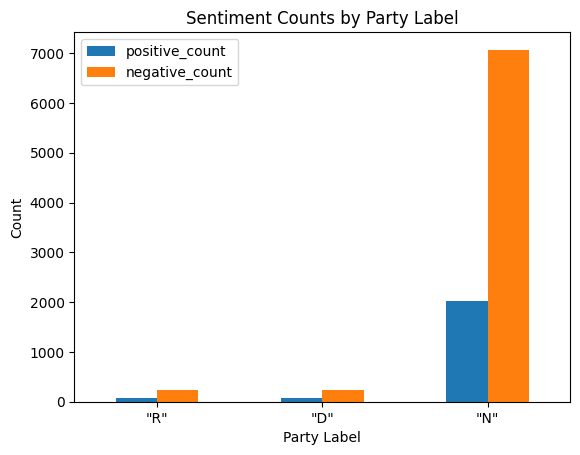

In [24]:
from pyspark.sql.functions import sum, when

sentiment_counts = df.groupBy('partyLabel').agg(
    sum(when(df['prediction'] == 1, 1).otherwise(0)).alias('positive_count'),
    sum(when(df['prediction'] == 0, 1).otherwise(0)).alias('negative_count')
)

sentiment_counts.show()

sentiment_counts = df.groupBy('partyLabel').agg(
    sum(when(df['prediction'] == 1, 1).otherwise(0)).alias('positive_count'),
    sum(when(df['prediction'] == 0, 1).otherwise(0)).alias('negative_count')
)

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_sentiment_counts = sentiment_counts.toPandas()

# Plotting the bar graph
pandas_sentiment_counts.plot(kind='bar', x='partyLabel', stacked=False)
plt.title('Sentiment Counts by Party Label')
plt.xlabel('Party Label')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

In [25]:
df.select('numUpvotes').describe().show()

23/12/08 22:17:53 WARN TaskSetManager: Stage 140 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+-------+------------------+
|summary|        numUpvotes|
+-------+------------------+
|  count|              9729|
|   mean|  9725.85219447014|
| stddev|24048.816664743634|
|    min|                 0|
|    max|            156752|
+-------+------------------+



In [26]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

temp_df = df.toPandas()
pandas_sentiment_counts = pd.concat([pandas_sentiment_counts, temp_df[['numUpvotes']]], axis=1)

conditions = [
    (col('numUpvotes') < 100),
    (col('numUpvotes') >= 100) & (col('numUpvotes') < 500),
    (col('numUpvotes') >= 500) & (col('numUpvotes') < 1500),
   (col('numUpvotes') >= 1500)
]

values = ['0-99', '100-499', '500-1499', '1500+']

# Create a new column 'upvote_range' based on conditions
df = df.withColumn('upvote_range', when(conditions[0], values[0])
                                   .when(conditions[1], values[1])
                                   .when(conditions[2], values[2])
                                   .when(conditions[3], values[3])
                                   .otherwise('Unknown'))
df.show()

# Group by 'upvote_range' and 'party_label' and count occurrences
result = df.groupBy('upvote_range', 'partyLabel').agg(count('*').alias('count'))

# Display the result
result.show()
pandas_result = result.toPandas()

print(pandas_result)


23/12/08 22:17:55 WARN TaskSetManager: Stage 149 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:17:58 WARN TaskSetManager: Stage 155 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+
|  id|numComments|numUpvotes|            postBody|           postTitle|      formattedTime|  combinedTextColumn|     textProbability|prediction| processedTextColumn|partyLabel|upvote_range|
+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+
|  26|          1|        19|                    |Poland changes co...|2023-10-28 15:00:01|Poland changes co...|[0.58090635546324...|       0.0|poland changes co...|       "N"|        0-99|
|  29|          1|         7|                    |Nomura reassesses...|2023-10-28 16:32:41|Nomura reassesses...|[0.98438761401133...|       0.0|nomura reassesses...|       "N"|        0-99|
| 474|          9|       281|                    |

23/12/08 22:18:01 WARN TaskSetManager: Stage 161 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+------------+----------+-----+
|upvote_range|partyLabel|count|
+------------+----------+-----+
|        0-99|       "D"|   85|
|     100-499|       "N"| 1734|
|    500-1499|       "N"|  756|
|     100-499|       "R"|   64|
|       1500+|       "N"| 3065|
|       1500+|       "D"|  165|
|       1500+|       "R"|  147|
|     100-499|       "D"|   40|
|        0-99|       "N"| 3532|
|        0-99|       "R"|   40|
|    500-1499|       "D"|   38|
|    500-1499|       "R"|   63|
+------------+----------+-----+



23/12/08 22:18:03 WARN TaskSetManager: Stage 170 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


   upvote_range partyLabel  count
0          0-99        "D"     85
1       100-499        "N"   1734
2      500-1499        "N"    756
3       100-499        "R"     64
4         1500+        "N"   3065
5         1500+        "D"    165
6         1500+        "R"    147
7       100-499        "D"     40
8          0-99        "N"   3532
9          0-99        "R"     40
10     500-1499        "D"     38
11     500-1499        "R"     63


23/12/08 22:18:05 WARN TaskSetManager: Stage 179 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+------------+----------+-----+
|upvote_range|prediction|count|
+------------+----------+-----+
|       1500+|       0.0| 2619|
|    500-1499|       0.0|  666|
|        0-99|       0.0| 2816|
|        0-99|       1.0|  841|
|     100-499|       0.0| 1449|
|       1500+|       1.0|  758|
|    500-1499|       1.0|  191|
|     100-499|       1.0|  389|
+------------+----------+-----+



23/12/08 22:18:08 WARN TaskSetManager: Stage 188 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


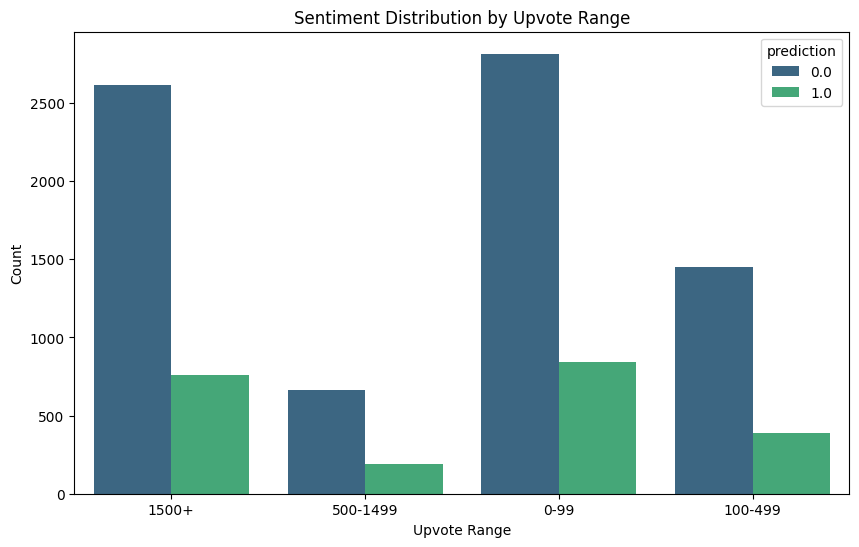

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Group by 'upvote_range' and 'party_label' and count occurrences
result = df.groupBy('upvote_range', 'prediction').agg(count('*').alias('count'))
result.show()

# Convert the result to a Pandas DataFrame for plotting
result_pd = result.toPandas()

# Plotting the bar graph using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='upvote_range', y='count', hue='prediction', data=result_pd, palette='viridis')
plt.title('Sentiment Distribution by Upvote Range')
plt.xlabel('Upvote Range')
plt.ylabel('Count')
plt.show()

23/12/08 22:18:12 WARN TaskSetManager: Stage 197 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


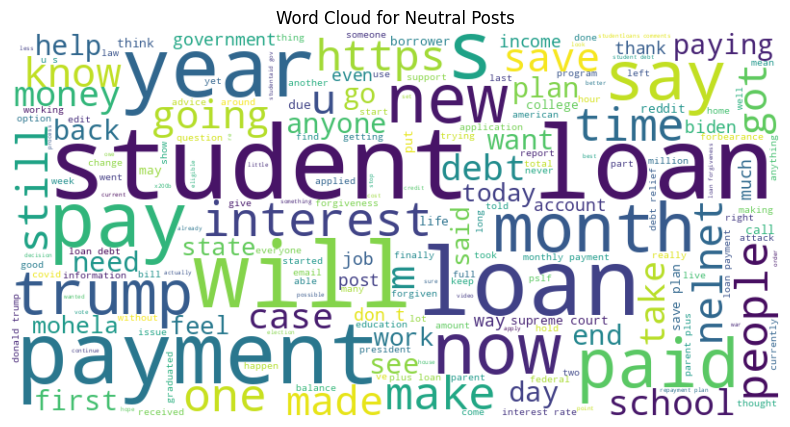

In [28]:
!pip install wordcloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Filter the DataFrame for negative posts (prediction == 0)
negative_posts = df.filter(col('partyLabel') == '"N"').select('processedTextColumn').rdd.flatMap(lambda x: x).collect()

# Concatenate the text data into a single string
text = ' '.join(negative_posts)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Posts')
plt.show()

23/12/08 22:18:17 WARN TaskSetManager: Stage 203 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


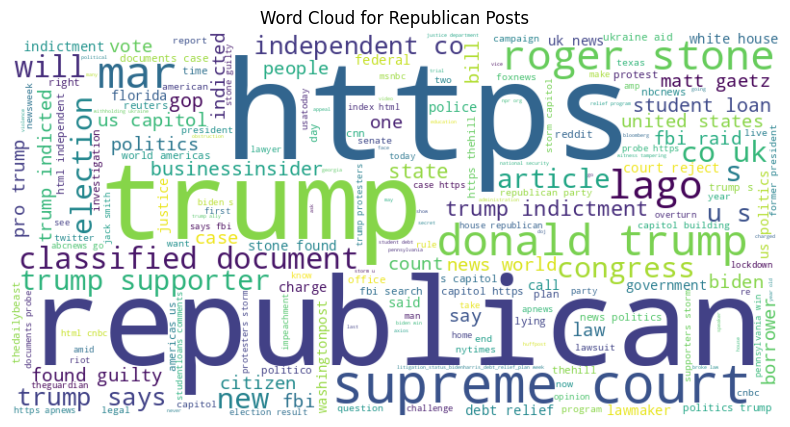

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Filter the DataFrame for negative posts (prediction == 0)
negative_posts = df.filter(col('partyLabel') == '"R"').select('processedTextColumn').rdd.flatMap(lambda x: x).collect()

# Concatenate the text data into a single string
text = ' '.join(negative_posts)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Republican Posts')
plt.show()

23/12/08 22:18:21 WARN TaskSetManager: Stage 209 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


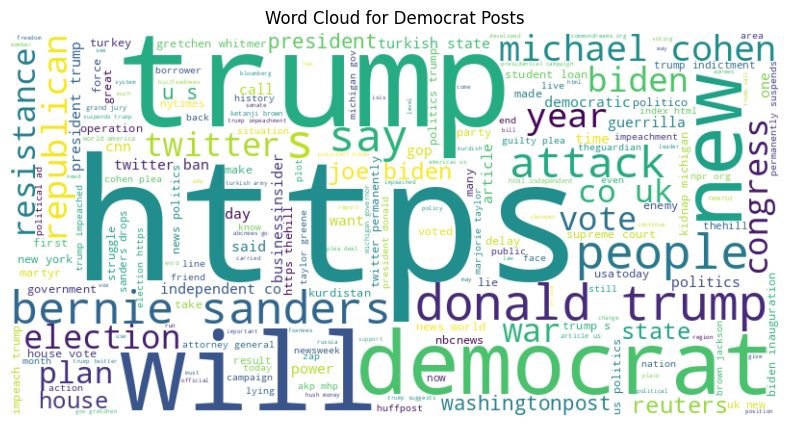

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Filter the DataFrame for negative posts (prediction == 0)
negative_posts = df.filter(col('partyLabel') == '"D"').select('processedTextColumn').rdd.flatMap(lambda x: x).collect()

# Concatenate the text data into a single string
text = ' '.join(negative_posts)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400,  background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Democrat Posts')
plt.show()

23/12/08 22:18:24 WARN TaskSetManager: Stage 215 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


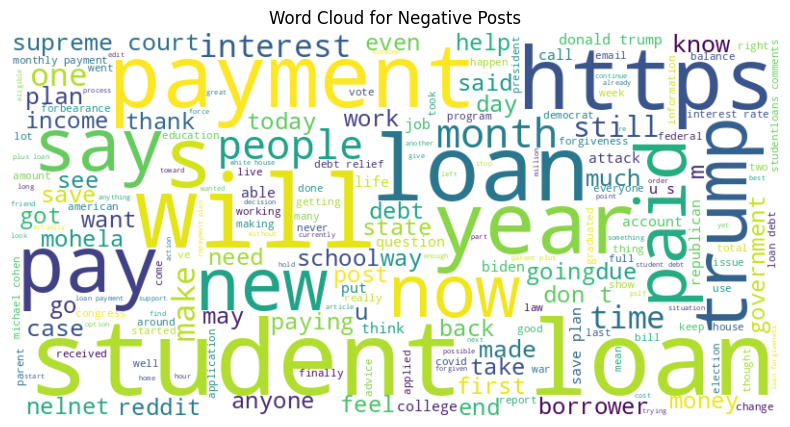

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Filter the DataFrame for negative posts (prediction == 0)
negative_posts = df.filter(col('prediction') == 0).select('processedTextColumn').rdd.flatMap(lambda x: x).collect()

# Concatenate the text data into a single string
text = ' '.join(negative_posts)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Posts')
plt.show()

23/12/08 22:18:28 WARN TaskSetManager: Stage 221 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


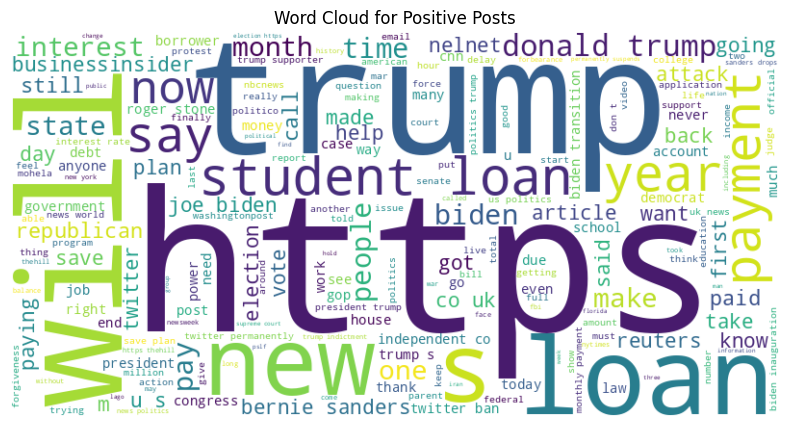

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Filter the DataFrame for positive posts (prediction == 1)
positive_posts = df.filter(col('prediction') == 1).select('processedTextColumn').rdd.flatMap(lambda x: x).collect()

# Concatenate the text data into a single string
text = ' '.join(positive_posts)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Posts')
plt.show()

23/12/08 22:18:31 WARN TaskSetManager: Stage 227 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------+--------------+
|partyLabel|positive_count|negative_count|
+----------+--------------+--------------+
|       "R"|            77|           237|
|       "D"|            84|           244|
|       "N"|          2018|          7069|
+----------+--------------+--------------+



23/12/08 22:18:34 WARN TaskSetManager: Stage 236 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


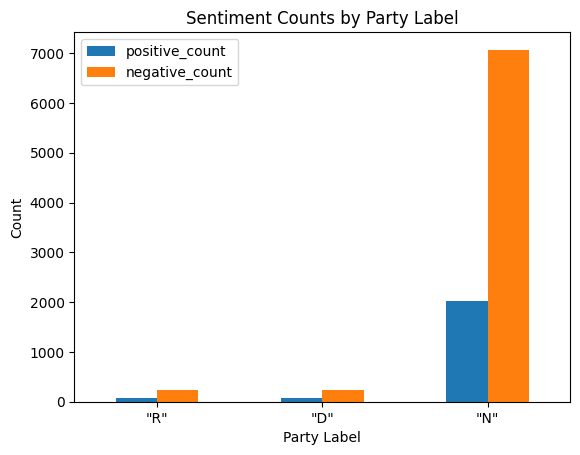

In [33]:
sentiment_counts = df.groupBy('partyLabel').agg(
    sum(when(df['prediction'] == 1, 1).otherwise(0)).alias('positive_count'),
    sum(when(df['prediction'] == 0, 1).otherwise(0)).alias('negative_count')
)

sentiment_counts.show()

sentiment_counts = df.groupBy('partyLabel').agg(
    sum(when(df['prediction'] == 1, 1).otherwise(0)).alias('positive_count'),
    sum(when(df['prediction'] == 0, 1).otherwise(0)).alias('negative_count')
)

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_sentiment_counts = sentiment_counts.toPandas()

# Plotting the bar graph
pandas_sentiment_counts.plot(kind='bar', x='partyLabel', stacked=False)
plt.title('Sentiment Counts by Party Label')
plt.xlabel('Party Label')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

23/12/08 22:18:37 WARN TaskSetManager: Stage 245 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:18:38 WARN TaskSetManager: Stage 246 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


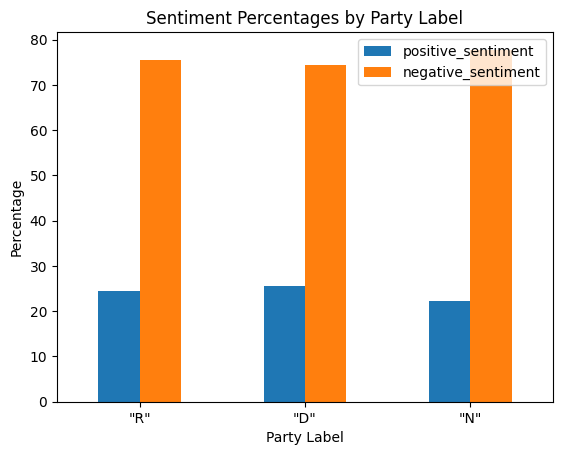

In [34]:
from pyspark.sql.functions import sum, when, count

# Calculate total counts for each party
total_counts = df.groupBy('partyLabel').agg(count('*').alias('total_count'))

# Calculate positive and negative counts
sentiment_counts = df.groupBy('partyLabel').agg(
    sum(when(df['prediction'] == 1, 1).otherwise(0)).alias('positive_count'),
    sum(when(df['prediction'] == 0, 1).otherwise(0)).alias('negative_count')
)

# Join sentiment counts with total counts
sentiment_counts = sentiment_counts.join(total_counts, on='partyLabel')

# Calculate percentages
sentiment_percentages = sentiment_counts.withColumn(
    'positive_sentiment', (sentiment_counts['positive_count'] / sentiment_counts['total_count']) * 100
).withColumn(
    'negative_sentiment', (sentiment_counts['negative_count'] / sentiment_counts['total_count']) * 100
)

# Select relevant columns
sentiment_percentages = sentiment_percentages.select(
    'partyLabel',
    'positive_sentiment',
    'negative_sentiment'
)

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_sentiment_percentages = sentiment_percentages.toPandas()

# Plotting the bar graph
pandas_sentiment_percentages.plot(kind='bar', x='partyLabel', stacked=False)
plt.title('Sentiment Percentages by Party Label')
plt.xlabel('Party Label')
plt.ylabel('Percentage')
plt.xticks(rotation=360)
plt.show()

In [35]:
# formatting the date column
df = df.withColumn("date", col("formattedTime").substr(1, 4))
df = df.withColumn("date", col("date").cast("int"))

df.show()


23/12/08 22:18:41 WARN TaskSetManager: Stage 261 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+----+
|  id|numComments|numUpvotes|            postBody|           postTitle|      formattedTime|  combinedTextColumn|     textProbability|prediction| processedTextColumn|partyLabel|upvote_range|date|
+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+----+
|  26|          1|        19|                    |Poland changes co...|2023-10-28 15:00:01|Poland changes co...|[0.58090635546324...|       0.0|poland changes co...|       "N"|        0-99|2023|
|  29|          1|         7|                    |Nomura reassesses...|2023-10-28 16:32:41|Nomura reassesses...|[0.98438761401133...|       0.0|nomura reassesses...|       "N"|        0-99|2023|
| 474|          9|       

23/12/08 22:18:44 WARN TaskSetManager: Stage 267 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


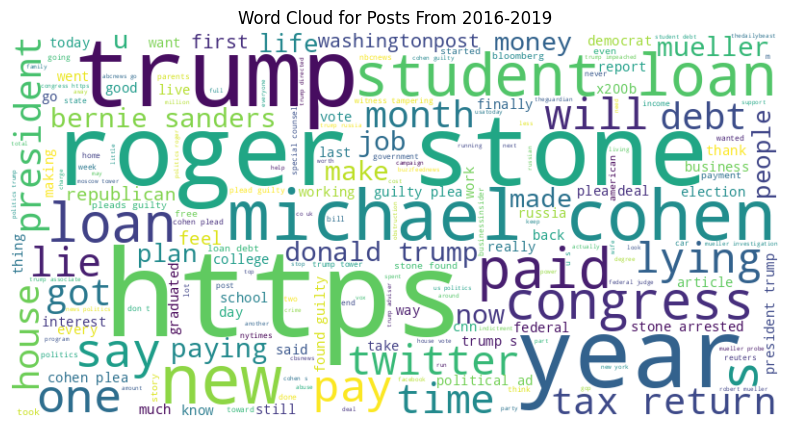

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import year

# 2016-2019 Word Cloud

# Filter the DataFrame for posts in date range 2016-2019
posts_in_2016_range = df.filter((col("date") >= 2016) & (col("date") <= 2019))
post_text_in_2016_range = posts_in_2016_range.select('processedTextColumn').rdd.flatMap(lambda x: x).collect()


# Concatenate the text data into a single string
text = ' '.join(post_text_in_2016_range)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Posts From 2016-2019')
plt.show()



23/12/08 22:18:47 WARN TaskSetManager: Stage 273 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


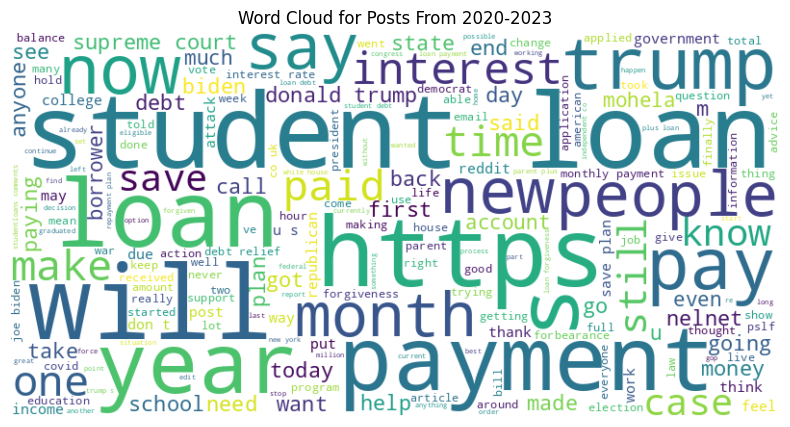

In [37]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import year

# 2020-2023 Word Cloud

# Filter the DataFrame for posts in date range 2020-2023
posts_in_2020_range = df.filter((col("date") >= 2020) & (col("date") <= 2023))
post_text_in_2020_range = posts_in_2020_range.select('processedTextColumn').rdd.flatMap(lambda x: x).collect()

# Concatenate the text data into a single string
text = ' '.join(post_text_in_2020_range)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Posts From 2020-2023')
plt.show()



23/12/08 22:18:51 WARN TaskSetManager: Stage 279 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


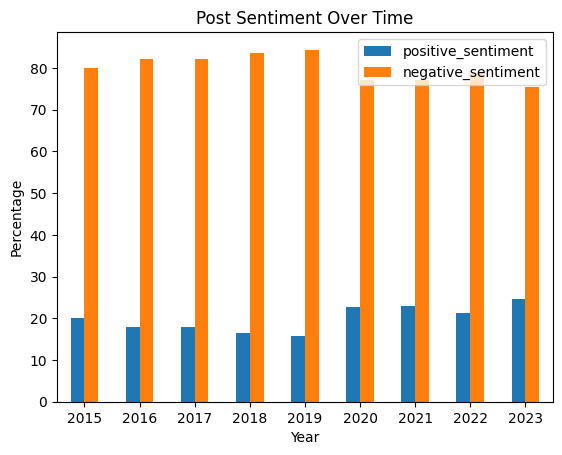

In [38]:
posts_in_2015_range = df.filter((col("date") >= 2015) & (col("date") <= 2023))

# Group by 'date' and calculate positive and negative counts
sentiment_over_time = posts_in_2015_range.groupBy('date').agg(
    sum(when(df['prediction'] == 1, 1).otherwise(0)).alias('positive_count'),
    sum(when(df['prediction'] == 0, 1).otherwise(0)).alias('negative_count'),
    count('*').alias('total_count')
)

# Calculate percentages
sentiment_percentages = sentiment_over_time.withColumn(
    'positive_sentiment', (col('positive_count') / col('total_count')) * 100
).withColumn(
    'negative_sentiment', (col('negative_count') / col('total_count')) * 100
)

# Select relevant columns
sentiment_percentages = sentiment_percentages.select(
    'date',
    'positive_sentiment',
    'negative_sentiment'
)

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_sentiment_over_time = sentiment_percentages.toPandas()

# Sorting so dates are in order
pandas_sentiment_over_time = pandas_sentiment_over_time.sort_values(by='date')

# Plotting the bar graph
pandas_sentiment_over_time.plot(kind='bar', x='date', stacked=False)
plt.title('Post Sentiment Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(rotation=360)
plt.show()

In [39]:
from pyspark.sql.functions import udf, col

# Define your function
def assign_keywords(text, keyword):
    if keyword in text:
        return 1
    else:
        return 0

# Register UDFs for each keyword
keywords = ["trump", "biden", "covid", "loans", "democrat", "republican", "ukraine", "russia", "china", "congress"]

for keyword in keywords:
    assign_keyword_udf = udf(lambda text: assign_keywords(text, keyword))
    df = df.withColumn(keyword, assign_keyword_udf(df.processedTextColumn))
df.show()

23/12/08 22:18:54 WARN TaskSetManager: Stage 288 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+----+-----+-----+-----+-----+--------+----------+-------+------+-----+--------+
|  id|numComments|numUpvotes|            postBody|           postTitle|      formattedTime|  combinedTextColumn|     textProbability|prediction| processedTextColumn|partyLabel|upvote_range|date|trump|biden|covid|loans|democrat|republican|ukraine|russia|china|congress|
+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+----+-----+-----+-----+-----+--------+----------+-------+------+-----+--------+
|  26|          1|        19|                    |Poland changes co...|2023-10-28 15:00:01|Poland changes co...|[0.58090635546324...|       0.0|poland changes co...|       "N"|        0-99|2023

In [40]:
df.drop("positive")
df.drop("negative")
df.show()    

23/12/08 22:18:57 WARN TaskSetManager: Stage 294 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.


+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+----+-----+-----+-----+-----+--------+----------+-------+------+-----+--------+
|  id|numComments|numUpvotes|            postBody|           postTitle|      formattedTime|  combinedTextColumn|     textProbability|prediction| processedTextColumn|partyLabel|upvote_range|date|trump|biden|covid|loans|democrat|republican|ukraine|russia|china|congress|
+----+-----------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+--------------------+----------+------------+----+-----+-----+-----+-----+--------+----------+-------+------+-----+--------+
|  26|          1|        19|                    |Poland changes co...|2023-10-28 15:00:01|Poland changes co...|[0.58090635546324...|       0.0|poland changes co...|       "N"|        0-99|2023

Including Daniel's Edits Below

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum
from pyspark.sql.functions import col
from pyspark.sql import functions as F


column_names = ["keyword", "negative", "positive"]
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
upvote_ranges = ["0-99", "100-499", "500-1499", "1500+"]

for year in years:
    column_names.append(str(year))
print(column_names)

for ranges in upvote_ranges:
    column_names.append(ranges)
print(column_names)

#list of lists containing all column values for each keyword
keyword_rows = []

# Loop through keywords and calculate sentiment counts and year counts
for keyword in keywords:
    # Filter rows where the current keyword exists
    filtered_df = df.filter(col(keyword) == 1)

    # get all sentiment counts
    zero_sum = filtered_df.select(F.sum(F.when(F.col("prediction") == 0, 1).otherwise(0)).alias("zeros"))
    one_sum = filtered_df.select(F.sum(F.when(F.col("prediction") == 1, 1).otherwise(0)).alias("ones"))

    # still need to concatonate text (all text from processedTextColumn of filtered_df into)

    results = zero_sum.union(one_sum)

    for year in years:
        results = results.union(filtered_df.select(F.sum(F.when(F.col("date") == year, 1).otherwise(0)).alias(f"{year}")))

    for ranges in upvote_ranges:
        results = results.union(filtered_df.select(F.sum(F.when(F.col("upvote_range") == ranges, 1).otherwise(0)).alias(f"{ranges}")))

    results = results.collect()
    #row with all column values for individual keyword
    individual_row = [row[0] for row in results]
    #add to list that will contain every row 
    keyword_rows.append(individual_row)

#creating lists for sentiment count columns
negative_col = [row[0] for row in keyword_rows]
positive_col = [row[1] for row in keyword_rows]
year_lists = {}
range_lists = {}

#creating lists for year count columns
for idx, year in enumerate(years):
    year_lists[year] = [row[idx+2] for row in keyword_rows]

for idx, ranges in enumerate(upvote_ranges):
    range_lists[ranges] = [row[idx+11] for row in keyword_rows]

tuple_list = []
for i in range(len(keywords)):
    tuple_list.append((keywords[i], negative_col[i], positive_col[i], year_lists[2015][i], year_lists[2016][i], 
                       year_lists[2017][i], year_lists[2018][i], year_lists[2019][i], year_lists[2020][i], year_lists[2021][i], 
                       year_lists[2022][i],year_lists[2023][i], range_lists['0-99'][i], range_lists['100-499'][i], range_lists['500-1499'][i], range_lists['1500+'][i]))



# Create dataframe
filtered_df = spark.createDataFrame(tuple_list, column_names)
filtered_df.show()

['keyword', 'negative', 'positive', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
['keyword', 'negative', 'positive', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '0-99', '100-499', '500-1499', '1500+']


23/12/08 22:19:01 WARN TaskSetManager: Stage 300 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:19:04 WARN TaskSetManager: Stage 302 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:19:12 WARN TaskSetManager: Stage 348 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:19:15 WARN TaskSetManager: Stage 350 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:19:21 WARN TaskSetManager: Stage 396 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:19:24 WARN TaskSetManager: Stage 398 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 22:19:30 WARN TaskSetManager: Stage 444 contains a task of very large size (1800 KiB). The maximum recommended task size is 1000 KiB.

+----------+--------+--------+----+----+----+----+----+----+----+----+----+----+-------+--------+-----+
|   keyword|negative|positive|2015|2016|2017|2018|2019|2020|2021|2022|2023|0-99|100-499|500-1499|1500+|
+----------+--------+--------+----+----+----+----+----+----+----+----+----+----+-------+--------+-----+
|     trump|    1045|     328|   2|  12|  39|  45|  58| 385| 152|  71| 608| 101|    233|     230|  809|
|     biden|     458|     131|   0|   0|   0|   1|   4| 144| 104|  97| 235| 108|    128|      73|  280|
|     covid|     173|      47|   0|   0|   0|   0|   0|  77|  41|  21|  81|  40|     92|      24|   64|
|     loans|    1000|     227|   0|   0|   4|  21|  56| 130| 105| 134| 777| 534|    579|      99|   15|
|  democrat|     244|      84|   0|   2|   4|  14|  16|  64|  53|  44| 116|  85|     40|      38|  165|
|republican|     278|      99|   1|   3|  11|  25|  11|  50|  62|  53| 144|  48|     68|      73|  188|
|   ukraine|      61|      17|   0|   0|   0|   1|   3|   2|   1

In [42]:
range_lists

{'0-99': [101, 108, 40, 534, 85, 48, 26, 50, 31, 76],
 '100-499': [233, 128, 92, 579, 40, 68, 18, 27, 13, 39],
 '500-1499': [230, 73, 24, 99, 38, 73, 9, 16, 6, 23],
 '1500+': [809, 280, 64, 15, 165, 188, 25, 69, 32, 103]}

In [43]:
filtered_df = filtered_df.withColumn('total', F.col('positive') + F.col('negative'))

filtered_df.show()


+----------+--------+--------+----+----+----+----+----+----+----+----+----+----+-------+--------+-----+-----+
|   keyword|negative|positive|2015|2016|2017|2018|2019|2020|2021|2022|2023|0-99|100-499|500-1499|1500+|total|
+----------+--------+--------+----+----+----+----+----+----+----+----+----+----+-------+--------+-----+-----+
|     trump|    1045|     328|   2|  12|  39|  45|  58| 385| 152|  71| 608| 101|    233|     230|  809| 1373|
|     biden|     458|     131|   0|   0|   0|   1|   4| 144| 104|  97| 235| 108|    128|      73|  280|  589|
|     covid|     173|      47|   0|   0|   0|   0|   0|  77|  41|  21|  81|  40|     92|      24|   64|  220|
|     loans|    1000|     227|   0|   0|   4|  21|  56| 130| 105| 134| 777| 534|    579|      99|   15| 1227|
|  democrat|     244|      84|   0|   2|   4|  14|  16|  64|  53|  44| 116|  85|     40|      38|  165|  328|
|republican|     278|      99|   1|   3|  11|  25|  11|  50|  62|  53| 144|  48|     68|      73|  188|  377|
|   ukrain

Storing Data in MySQL 

In [44]:
db_connection = mysql.connector.connect(user="group6", password="1234")
db_cursor = db_connection.cursor()
db_cursor.execute("USE cs179g;")
db_cursor.execute("CREATE TABLE IF NOT EXISTS master_table(keyword TINYTEXT, negative INT, \
                   positive INT, twenty_fifteen INT, twenty_sixteen INT, twenty_seventeen INT, twenty_eighteen INT, twenty_nineteen INT, twenty_twenty INT, twenty_twenty_one INT, twenty_twenty_two INT, twenty_twenty_three INT, \
                  zero INT, one_hundred INT, five_hundred INT, fifteen_hundred INT, total INT);")
filtered_df = filtered_df.toPandas()

temp = list(filtered_df.itertuples(index=False, name=None))
#df_string = ",".join(["(" + ",".join([str(w) for w in wt]) + ")" for wt in temp])
df_string = ",".join(["('" + "','".join([str(w) for w in wt]) + "')" for wt in temp])


print(df_string)
db_cursor.execute("INSERT INTO master_table(keyword, negative, \
                    positive, twenty_fifteen, twenty_sixteen, twenty_seventeen, twenty_eighteen, twenty_nineteen, twenty_twenty, twenty_twenty_one, twenty_twenty_two, twenty_twenty_three, \
                  zero, one_hundred, five_hundred, fifteen_hundred, total) VALUES " + df_string + ";")

('trump','1045','328','2','12','39','45','58','385','152','71','608','101','233','230','809','1373'),('biden','458','131','0','0','0','1','4','144','104','97','235','108','128','73','280','589'),('covid','173','47','0','0','0','0','0','77','41','21','81','40','92','24','64','220'),('loans','1000','227','0','0','4','21','56','130','105','134','777','534','579','99','15','1227'),('democrat','244','84','0','2','4','14','16','64','53','44','116','85','40','38','165','328'),('republican','278','99','1','3','11','25','11','50','62','53','144','48','68','73','188','377'),('ukraine','61','17','0','0','0','1','3','2','1','12','59','26','18','9','25','78'),('russia','122','40','0','0','11','8','8','15','1','18','100','50','27','16','69','162'),('china','64','18','0','0','0','1','0','12','13','4','51','31','13','6','32','82'),('congress','184','57','0','3','3','9','17','32','42','27','65','76','39','23','103','241')


In [45]:
filtered_df

,keyword,negative,positive,2015,2016,2017,2018,2019,2020,2021,2022,2023,0-99,100-499,500-1499,1500+,total
0,trump,1045,328,2,12,39,45,58,385,152,71,608,101,233,230,809,1373
1,biden,458,131,0,0,0,1,4,144,104,97,235,108,128,73,280,589
2,covid,173,47,0,0,0,0,0,77,41,21,81,40,92,24,64,220
3,loans,1000,227,0,0,4,21,56,130,105,134,777,534,579,99,15,1227
4,democrat,244,84,0,2,4,14,16,64,53,44,116,85,40,38,165,328
5,republican,278,99,1,3,11,25,11,50,62,53,144,48,68,73,188,377
6,ukraine,61,17,0,0,0,1,3,2,1,12,59,26,18,9,25,78
7,russia,122,40,0,0,11,8,8,15,1,18,100,50,27,16,69,162
8,china,64,18,0,0,0,1,0,12,13,4,51,31,13,6,32,82
9,congress,184,57,0,3,3,9,17,32,42,27,65,76,39,23,103,241


Testing connection to MySQL via PySpark

In [46]:
proof_df = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3306/cs179g") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "master_table") \
    .option("user", "group6").option("password", "1234").load()
print(proof_df)
db_cursor.execute("FLUSH TABLES;")
db_cursor.execute("SELECT * FROM master_table LIMIT 5;")
print(db_cursor.fetchall())

Loading class `com.mysql.jdbc.Driver'. This is deprecated. The new driver class is `com.mysql.cj.jdbc.Driver'. The driver is automatically registered via the SPI and manual loading of the driver class is generally unnecessary.


DataFrame[keyword: string, negative: int, positive: int, twenty_fifteen: int, twenty_sixteen: int, twenty_seventeen: int, twenty_eighteen: int, twenty_nineteen: int, twenty_twenty: int, twenty_twenty_one: int, twenty_twenty_two: int, twenty_twenty_three: int, zero: int, one_hundred: int, five_hundred: int, fifteen_hundred: int, total: int]
[('trump', 1045, 328, 2, 12, 39, 45, 58, 385, 152, 71, 608, 101, 233, 230, 809, 1373), ('biden', 458, 131, 0, 0, 0, 1, 4, 144, 104, 97, 235, 108, 128, 73, 280, 589), ('covid', 173, 47, 0, 0, 0, 0, 0, 77, 41, 21, 81, 40, 92, 24, 64, 220), ('loans', 1000, 227, 0, 0, 4, 21, 56, 130, 105, 134, 777, 534, 579, 99, 15, 1227), ('abortion', 44, 21, 0, 0, 0, 1, 1, 2, 7, 9, 43, 24, 12, 9, 20, 65)]
